<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Barcelona_School_of_Economics_logo.svg/2560px-Barcelona_School_of_Economics_logo.svg.png" width="500" height="200">

# <b> Title TDB </b>


#### <i> Group Members: Marta Sala, Soledad Monge, Maria Aleman Hernandez 
#### <i> Master Thesis Project

<b>Project Summary:</b> 


<br>


<b>Objective:</b>


<br>

<b>Jupyter Notebook Outline:</b>

1. Load libraries
2. Load data files and initial preprocessing
3. Merge data
4. Handle missing values
5. Feature Engineer
6. Explanatory data analysis
7. Create model with HDBSCAN
8. Maps
9. Analysis on individual competitor banks
10. Final conclusions

<br>

#### **Step 1: Load libraries**
--- 

<b>Steps done in this section:</b>

- Install packages and versions (if needed)


- Import packages

In [127]:
# Import the packages
import os
import re
# import shap
import hdbscan
import openpyxl
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

#### **Step 2: Load data files and initial preprocessing**
---

<b>Data Files Descriptions:</b>
     
1. 'banks_location.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

2. 'business.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

3. 'sociodemographic.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

4. 'secciones_censales_sociodemo_2014.shp'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

In [128]:
# Load the data
sociodemo = pd.read_excel("data/sociodemographic.xlsx")
banks = pd.read_excel("data/banks_location.xlsx")
business = pd.read_excel("data/business.xlsx")

<b>2.1. BANKS

<b>Steps done in this section:</b>
- From CUSEC column, create municipality column.
- Normalized names of the entity column and keep only the 5 competitors banks (Sabadell, BBVA, Santander, CaixaBank and Bankinter).
- Aggregate the data by municipality and entity, adding the number of branches.
- Create a new data frame (banks_municip_final) that contains the number of banks (total and by entity) per municipality.

In [129]:
banks['CUSEC'] = banks['CUSEC'].astype(str)
# Create 'municipality' column (CUSEC without the last 5 digits)
banks['municipality'] = banks['CUSEC'].str[:-5]

# Function to normalize names of banks in the "ENTITY" column
def normalize_entity(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e in ['BBVA', 'BANCO BILBAO VIZCAYA ARGENTARIA']:
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Others'
    
# Apply the function to the original column
banks['entity'] = banks['ENTITY'].apply(normalize_entity)

# Keep only the 5 top entities
banks = banks[banks['entity'] != 'Others']

# Group by municipality and entity, adding the number of branches
banks_municip = banks.groupby(['municipality', 'entity'])['NUM_BRANCHES'].sum().reset_index()

# Pivot so that each entity is in a column
banks_municip_final = banks_municip.pivot(index='municipality', columns='entity', values='NUM_BRANCHES').fillna(0)

# Rename columns
banks_municip_final.columns.name = None
banks_municip_final = banks_municip_final.rename(columns={'CaixaBank': 'banks_CaixaBank', 'Santander': 'banks_Santander', 'Sabadell': 'banks_Sabadell', 'Bankinter': 'banks_Bankinter', 'BBVA': 'banks_BBVA'})

# Create column with the total number of banks (adding the 5 entity columns)
banks_municip_final['banks_total'] = banks_municip_final.sum(axis=1)

# Reset index so that municipality is a column
banks_municip_final = banks_municip_final.reset_index()

<b>2.2. SOCIODEMOGRAPHIC

<b>Steps done in this section:</b>
- From CUSEC column, create municipality column.
- Create "high" column which contain the number of high income people in each CUSEC.
- Create “professional” column which contain the number of professionals in each CUSEC. This variable include managers, technicians, skilled workers and entrepreneurs.
- Create "europeans" column which contain the number of spanish people and foreigns from Europe in each CUSEC.
- Aggregate tot_pop, high, professionals and europeans (frequency variables) to obtain municipality levels. 
- Create new data frame (sociodemo_municip_final) that contains "high", "professionals", "europeans" and "tot_pop" per municipality. 

In [130]:
sociodemo['CUSEC'] = sociodemo['CUSEC'].astype(str)
# Create 'municipality' column (CUSEC without the last 5 digits)
sociodemo['municipality'] = sociodemo['CUSEC'].str[:-5]

# Create columns
sociodemo['high'] = (sociodemo['v_nse6'] + sociodemo['v_nse7'] + sociodemo['v_nse8'] + sociodemo['v_nse9'])
sociodemo['professionals'] = (sociodemo['v_deyap'] + sociodemo['v_tpcint'] + sociodemo['v_tprda'] + sociodemo['v_tcuap'] + sociodemo['v_emspr'] + sociodemo['v_atcim'] + sociodemo['v_emnpr'])
sociodemo['europeans'] = sociodemo['tot_espa'] + sociodemo['v_EURO']

# Keep only final columns and tot_pob
final_columns = ['municipality', 'tot_pob', 'high', 'professionals', 'europeans'] 
sociodemo_municip = sociodemo[final_columns]

# Group by municipality and add all companies
sociodemo_municip_final = sociodemo_municip.groupby('municipality').sum().reset_index()

<b>2.3. BUSINESS

<b>Steps done in this section:</b>
- From CUSEC column, create municipality column.
- Aggregate all the data in municipality levels (all columns represent number of companies).
- Note that some column names represent activity division codes (1-99) instead of high-level sections (A–U). To simplify the classification, a mapping was applied to reassign the original activity division code into their corresponding high-level sections. This transformation allows for easier aggregation and analysis across standardized economic sectors. 
-  The original business_municip dataset is split into four specific subsets to facilitate targeted analysis: business_companies, business_new_companies, business_profit and business_billings.
- Obtained the top 10 economic sectors.
- Create a data frame (business_munip_final) that contain the following columns: Number of companies of the 10 top sectors, Number of New Companies of the top 10 sectors, Number of medium and big companies of the top 10 sectors and Number of High Profit Companies of the Top 10 sectors. 

In [131]:
# Create 'municipality' column (CUSEC without the last 5 digits)
business['CUSEC'] = business['CUSEC'].astype(str)
business['municipality'] = business['CUSEC'].str[:-5]
business = business.drop(columns=['CUSEC'])

# Group by municipality and add all companies
business_municip = business.groupby('municipality').sum().reset_index()

# Create a dictionary mapping activity divisions to sections (A–U)
division_to_section = {
    'A': list(range(1, 4)),        # 01 to 03
    'B': list(range(5, 10)),       # 05 to 09
    'C': list(range(10, 34)),      # 10 to 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 to 39
    'F': list(range(41, 44)),      # 41 to 43
    'G': list(range(45, 48)),      # 45 to 47
    'H': list(range(49, 54)),      # 49 to 53
    'I': list(range(55, 57)),      # 55 to 56
    'J': list(range(58, 64)),      # 58 to 63
    'K': list(range(64, 67)),      # 64 to 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 to 75
    'N': list(range(77, 83)),      # 77 to 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 to 88
    'R': list(range(90, 94)),      # 90 to 93
    'S': list(range(94, 97)),      # 94 to 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# Function to map a division number (e.g., "10") to its corresponding section code (e.g., "C")
def map_to_section(col_name):
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  # Return original column name if no match is found

# Apply the mapping to all column names in the DataFrame
business_municip.columns = [map_to_section(col) for col in business_municip.columns]

# Create subsets 
business_companies = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 1:22]], axis=1)
business_new_companies = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 22:42]], axis=1)
business_new_companies['U_ActivitiesOfExtraterrestrialOrganizations_NumCompaniesNewCreation'] = 0
business_profit = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 68:498]], axis=1)
business_billings = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 528:1282]], axis=1)

2.3.1 Top 10 Economic Sectors

This subsection performs a comprehensive sector-level analysis to identify the top economic sectors based on their relationship with banking activity and business performance. It calculates the correlation between the number of bank branches and the number of companies per economic sector, assesses the growth rate of new companies, counts medium and large businesses based on billing data, and identifies high-profit firms by sector. These metrics are merged into a unified dataset, and each sector is ranked across four dimensions: correlation with banks, growth rate, total number of companies, and number of high-profit companies. Finally, an average ranking is computed to highlight the most promising sectors overall, which are visualized in a bar chart sorted by mean rank (lower is better).

In [132]:
# Dictionary to standardize sector names
rename_dict = {
    'A': 'Agriculture',
    'B': 'Extractive',
    'C': 'Manufacturing',
    'D': 'Energy',
    'E': 'Water & Waste',
    'F': 'Construction',
    'G': 'Wholesale & Retail',
    'H': 'Transport',
    'I': 'Hospitality',
    'J': 'Info & Comms',
    'K': 'Finance',
    'L': 'Real Estate',
    'M': 'Professional Services',
    'N': 'Admin Services',
    'O': 'Public Admin',
    'P': 'Education',
    'Q': 'Health & Social',
    'R': 'Arts & Recreation',
    'S': 'Other Services',
    'T': 'Household Services',
    'U': 'Extraterrestrial'
}

2.3.1.1. Correlation beetwen Number of banks and Number of Companies by Economic Sectors

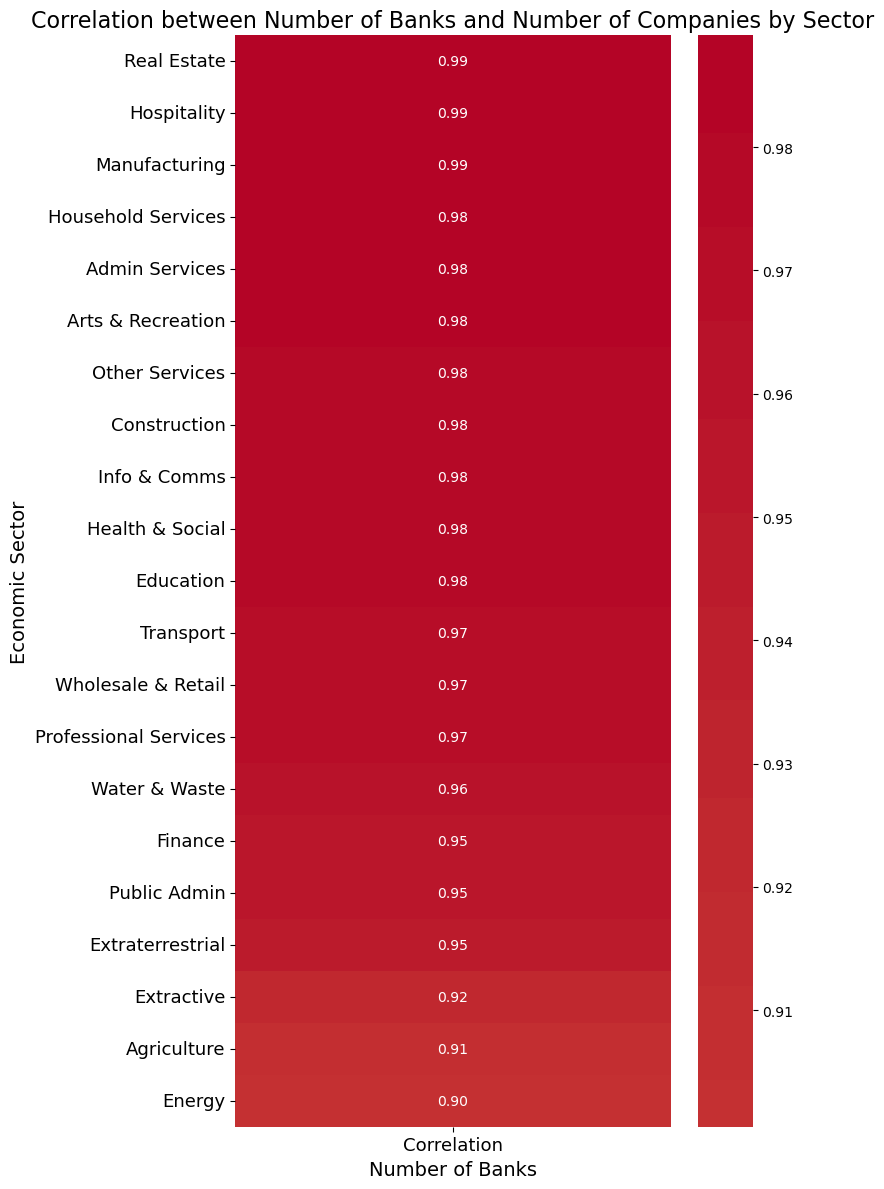

In [133]:
# Merge banks and companies data
banks_municip_final['municipality'] = banks_municip_final['municipality'].astype(str)
df_banks_companies = business_companies.merge(banks_municip_final, on='municipality', how='left')
df_banks_companies.fillna(0, inplace=True)

# Define relevant columns
bank_cols = ['banks_total']
sector_cols = [col for col in business_companies.columns if col != 'municipality']

# Calculate the correlation matrix
correlation_matrix = df_banks_companies[bank_cols + sector_cols].corr()

# Correlation between banks and economic sectors
correlation_table = correlation_matrix.loc[bank_cols, sector_cols]
correlation_table_sorted = correlation_table.T.sort_values(by='banks_total', ascending=False)

# Convert to DataFrame
correlation_df = correlation_table_sorted.reset_index()
correlation_df.columns = ['Sector', 'Correlation']

# Extract letters and apply clean names
correlation_df['Sector_letter'] = correlation_df['Sector'].str.extract(r'^([A-U])_')
correlation_df['Sector_clean'] = correlation_df['Sector_letter'].map(rename_dict)

# Plot
plt.figure(figsize=(8, 12))
sns.heatmap(
    correlation_df.set_index('Sector_clean')[['Correlation']],
    cmap='coolwarm', center=0, annot=True, fmt=".2f"
)
plt.title('Correlation between Number of Banks and Number of Companies by Sector', fontsize=16)
plt.ylabel('Economic Sector', fontsize=14)
plt.xlabel('Number of Banks', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Correlation
correlation_df = correlation_df.drop(columns=['Sector', 'Sector_letter'])
correlation_df = correlation_df.rename(columns={'Sector_clean': 'Sector'})

2.3.1.2. Growth Rate of Companies by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\1885086546.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='growth_rate', y='Sector_clean', data=growth_df_sorted, palette='viridis')


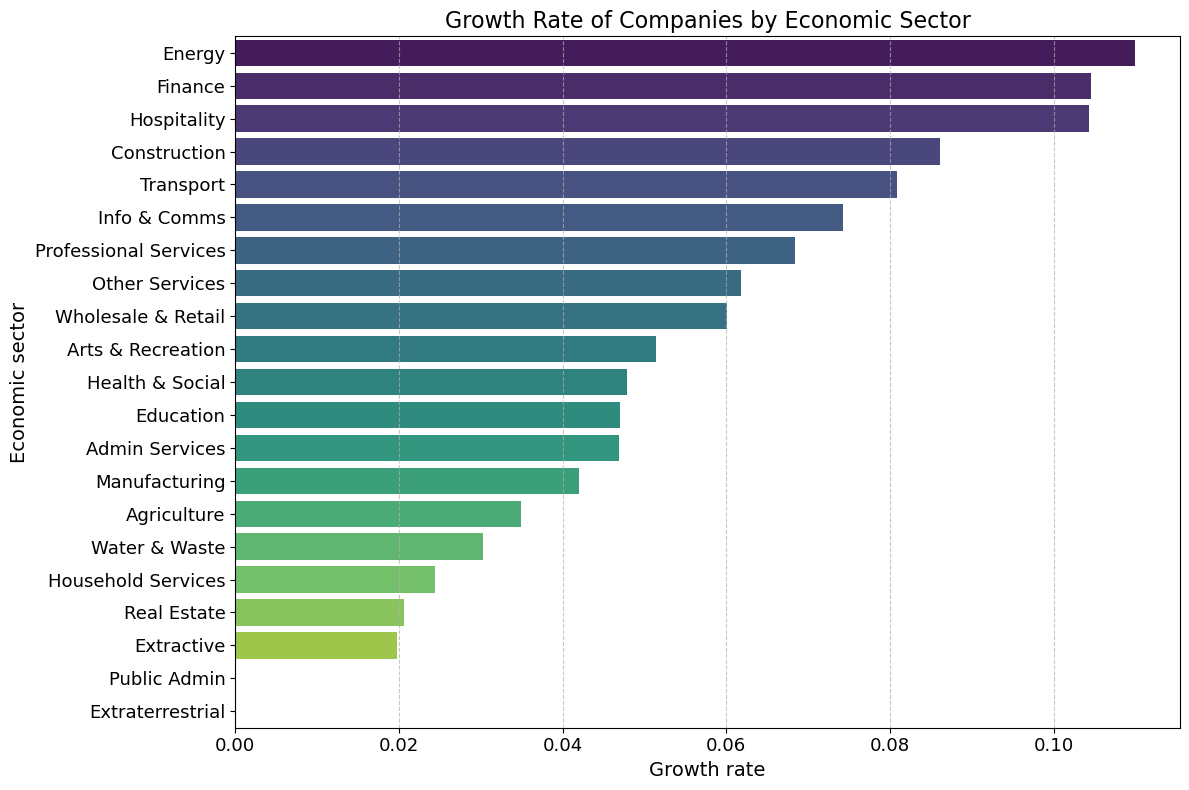

In [134]:
# Combine companies and new companies datasets 
business_combined = pd.concat([business_companies, business_new_companies.drop(columns='municipality')], axis=1)

# Add total companies and new companies per economic sector
total_companies_sector = business_combined.drop(columns='municipality').sum()

# Separate total and new companies
total_companies = total_companies_sector.iloc[0:21].reset_index()
new_companies = total_companies_sector.iloc[21:].reset_index()

# Extract sector letter (A–U)
sector_letters = [name.split('_')[0] for name in total_companies['index']]

# Create DataFrame
growth_df = pd.DataFrame({
    'Sector': sector_letters,
    'total_companies': total_companies[0].values,
    'new_companies': new_companies[0].values
})

# Calculate growth rate
growth_df['growth_rate'] = growth_df['new_companies'] / growth_df['total_companies']

# Add clean names
growth_df['Sector_clean'] = growth_df['Sector'].map(rename_dict)

# Sort 
growth_df_sorted = growth_df.sort_values(by='growth_rate', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='growth_rate', y='Sector_clean', data=growth_df_sorted, palette='viridis')
plt.title('Growth Rate of Companies by Economic Sector', fontsize=16)
plt.xlabel('Growth rate', fontsize=14)
plt.ylabel('Economic sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and growth_rate
growth_rate_df = growth_df_sorted[['Sector_clean', 'growth_rate']].reset_index(drop=True)
growth_rate_df = growth_rate_df.rename(columns={'Sector_clean': 'Sector'})


2.3.1.3. Number of Medium and Big Companies by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\3325556326.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Companies', y='Sector_clean', data=total_companies_sector, palette='viridis')


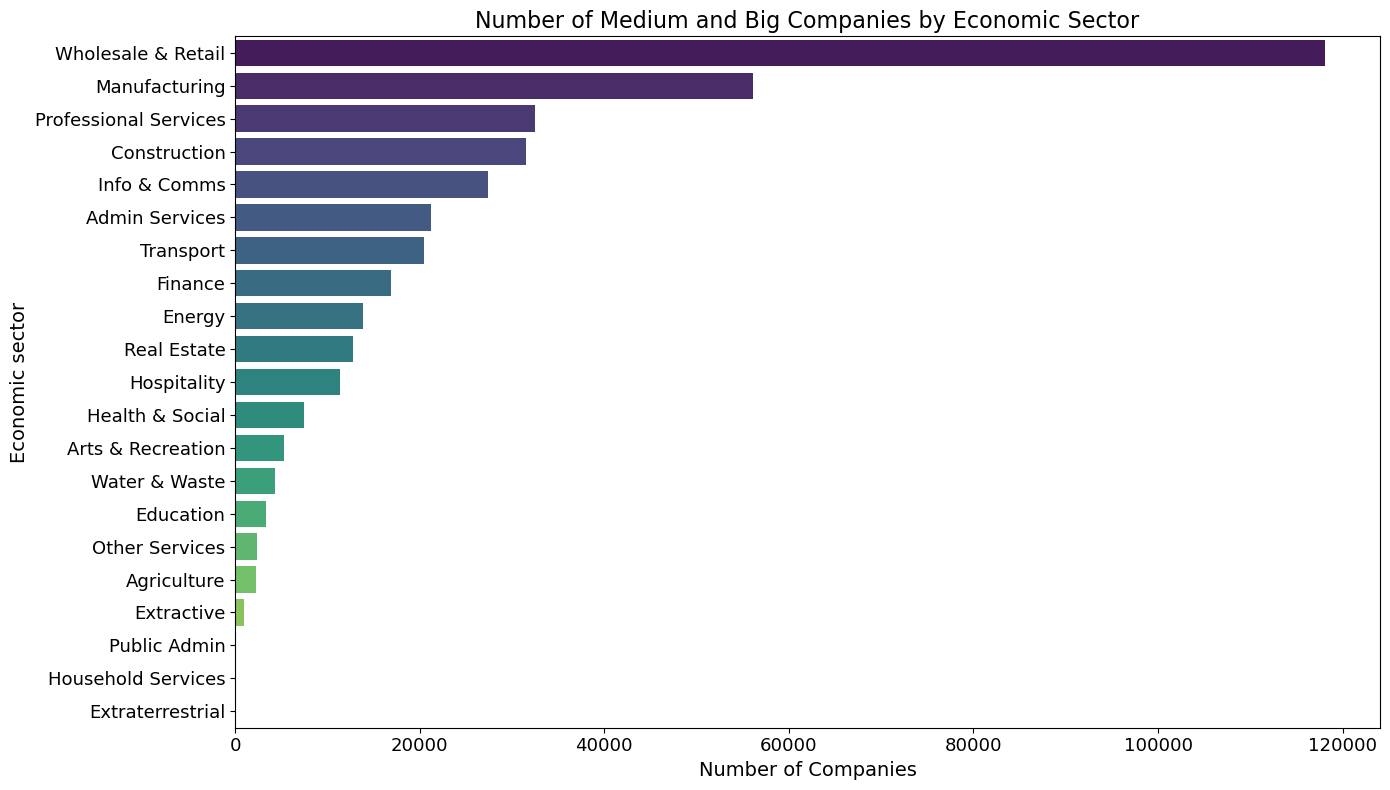

In [135]:
# Select columns of medium and large companies (billing > 5 million)
cols_ml = [col for col in business_billings.columns if 
           col.endswith('Between5000001And25000000_Billing') or
           col.endswith('Between25000001And50000000_Billing') or
           col.endswith('MoreThan50000000_Billing')]

# Subset with that columns
business_ml = business_billings[cols_ml]

# Group by sector letter
sums_by_letter = {}
for col in business_ml.columns:
    letter = col.split('_')[0]
    if letter not in sums_by_letter:
        sums_by_letter[letter] = business_ml[col]
    else:
        sums_by_letter[letter] += business_ml[col]

# Convert to DataFrame
df_sector_sums = pd.DataFrame(sums_by_letter)

# Total per economic sector
total_companies_sector = df_sector_sums.sum().reset_index()
total_companies_sector.columns = ['Sector', 'Total_Companies']

# Add missing sectors (T and U) with 0
missings = pd.DataFrame({
    'Sector': ['T', 'U'],
    'Total_Companies': [0, 0]
})
total_companies_sector = pd.concat([total_companies_sector, missings], ignore_index=True)

# Add clean names
total_companies_sector['Sector_clean'] = total_companies_sector['Sector'].map(rename_dict)

# Sort by number of companies
total_companies_sector = total_companies_sector.sort_values(by='Total_Companies', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Total_Companies', y='Sector_clean', data=total_companies_sector, palette='viridis')
plt.title('Number of Medium and Big Companies by Economic Sector', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Economic sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Total_Companies
total_companies_sector = total_companies_sector[['Sector_clean', 'Total_Companies']]
total_companies_sector = total_companies_sector.rename(columns={'Sector_clean': 'Sector'})


2.3.1.4. Number Companies with high profits by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\1149281176.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Companies_profit', y='Sector_clean', data=total_companies_sector_profit, palette='viridis')


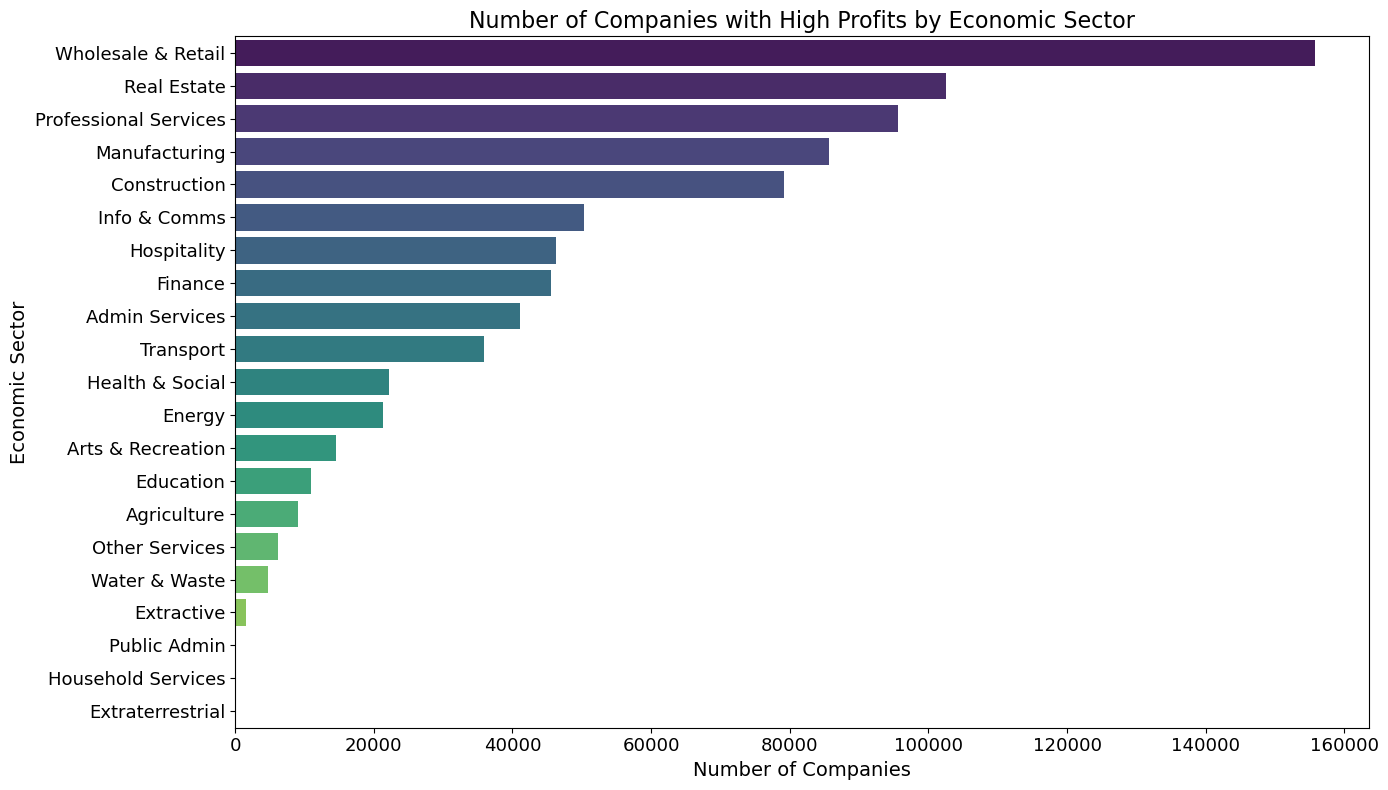

In [136]:
# Select columns of high profit companies (profit > 100,000)
cols_profit = [col for col in business_profit.columns if 
               col.endswith('Between100001And500000_Profit') or
               col.endswith('Between500001And1000000_Profit') or
               col.endswith('MoreThan1000000_Profit')]

# Subset with that columns
business_high_profit = business_profit[cols_profit]

# # Group by sector letter
sums_by_letter = {}
for col in business_high_profit.columns:
    letter = col.split('_')[0]
    if letter not in sums_by_letter:
        sums_by_letter[letter] = business_high_profit[col]
    else:
        sums_by_letter[letter] += business_high_profit[col]

# Convert to DataFrame
df_sector_sums = pd.DataFrame(sums_by_letter)

# Total per economic sector
total_companies_sector_profit = df_sector_sums.sum().reset_index()
total_companies_sector_profit.columns = ['Sector', 'Total_Companies_profit']

# Add clean names
total_companies_sector_profit['Sector_clean'] = total_companies_sector_profit['Sector'].map(rename_dict)

# Sort
total_companies_sector_profit = total_companies_sector_profit.sort_values(by='Total_Companies_profit', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Total_Companies_profit', y='Sector_clean', data=total_companies_sector_profit, palette='viridis')
plt.title('Number of Companies with High Profits by Economic Sector', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Economic Sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Total_Companies_profit
total_companies_sector_profit = total_companies_sector_profit[['Sector_clean', 'Total_Companies_profit']]
total_companies_sector_profit = total_companies_sector_profit.rename(columns={'Sector_clean': 'Sector'})


2.3.1.5. Ranking

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\236056951.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_rank', y='Sector', data=ranking_df_sorted, palette='crest_r')


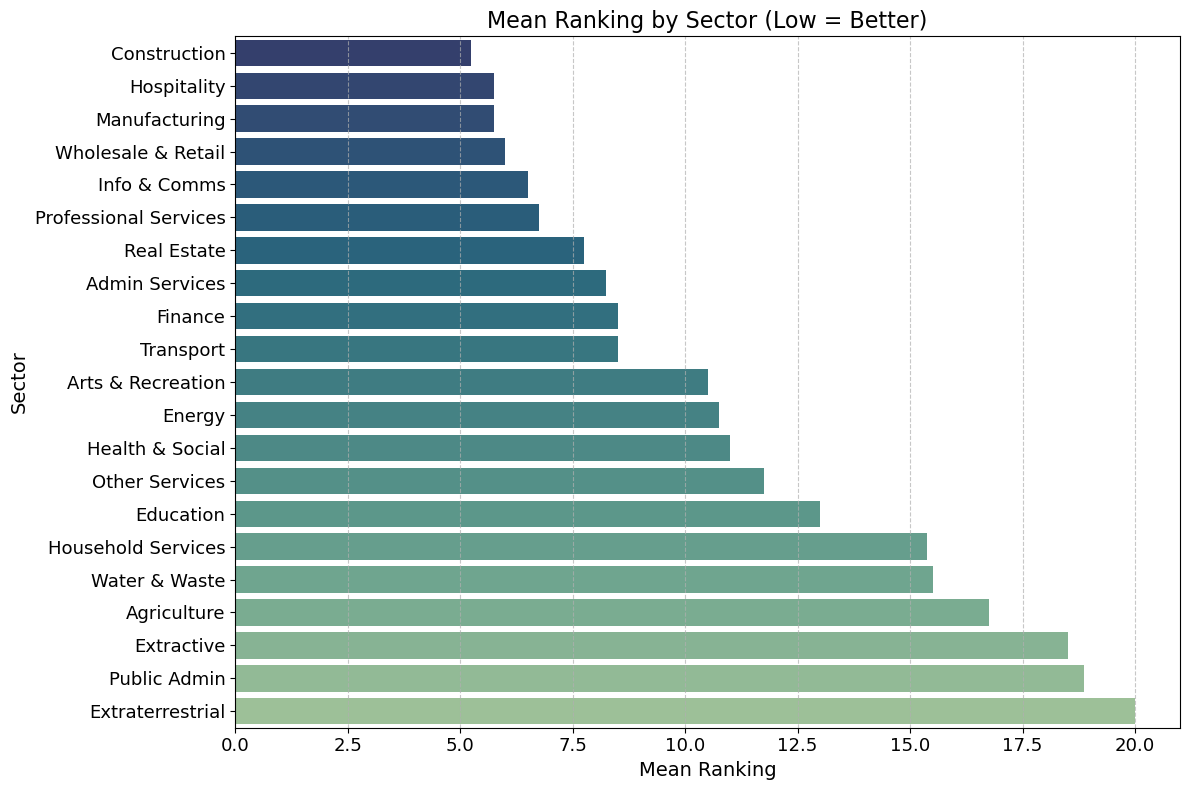

In [137]:
# Merge the DataFrames successively by the 'Sector' column
merged_df = correlation_df.merge(growth_rate_df, on='Sector', how='outer')
merged_df = merged_df.merge(total_companies_sector, on='Sector', how='outer')
merged_df = merged_df.merge(total_companies_sector_profit, on='Sector', how='outer')

# Create rankings (higher value = better ranking)
ranking_df = merged_df.copy()
ranking_df['rank_corr'] = ranking_df['Correlation'].rank(ascending=False)
ranking_df['rank_growth'] = ranking_df['growth_rate'].rank(ascending=False)
ranking_df['rank_size'] = ranking_df['Total_Companies'].rank(ascending=False)
ranking_df['rank_profit'] = ranking_df['Total_Companies_profit'].rank(ascending=False)

# Export the DataFrame c
df_rankings = ranking_df[['Sector', 'rank_corr', 'rank_growth', 'rank_size', 'rank_profit']]
df_rankings.to_csv('sector_rankings.csv', index=False)

# Calculate average ranking and sort
ranking_df['mean_rank'] = ranking_df[['rank_corr', 'rank_growth', 'rank_size', 'rank_profit']].mean(axis=1)
ranking_df_sorted = ranking_df.sort_values('mean_rank')

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='mean_rank', y='Sector', data=ranking_df_sorted, palette='crest_r')
plt.title('Mean Ranking by Sector (Low = Better)', fontsize=16)
plt.xlabel('Mean Ranking', fontsize=14)
plt.ylabel('Sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [138]:
# Letters of the 10 sectors
letters = ('F', 'I', 'G', 'M', 'C', 'J', 'N', 'H', 'L', 'R')

2.3.2 Subsets with relevant columns

1. Subset 1: use the columns of the business df that contain the Number of companies by sector and aggregate those of the 10 sectors to obtain NumCompanies_10S.
2. Subset 2: use the columns of the business df that contain the Number of New companies by sector and aggregate those of the 10 sectors to obtain NumNewCompanies_10S.
3. Subset 3: use the columns of the business df that contain the number of companies of each billing ranges by sector. However, this columns names are in division categories (01 to 99), so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the billing ranges represents medium and big companies (more than 5000001 billings). Finally we agregate that columns to obtain NumCompanies_ML_10S.
4. Subset 4: use the columns of the business df that contain the number of companies of each profit ranges by sector. However, this columns names are in division categories (01 to 99) so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the profit ranges represents high profit companies (more than 100001 profits). Finally we agregate that columns to obtain NumCompanies_HP_10S.
- Merge all subsets to create business_municip_final wich contains 5 columns: municipality, NumCompanies_10S, NumNewCompanies_10S, NumCompanies_ML_10S and NumCompanies_HP_10S

2.3.2.1 Number of Companies Top 10 sectors

In [139]:
# Filter columns that begin with letters of top 10 sectors
filtered_columns = [col for col in business_companies.columns if col.startswith(letters)]

# Create a new df with that columns and municipality 
business_subset1 = business_companies[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies of the 10 sectors by municipality
sector_columns = [col for col in business_subset1.columns if col != 'municipality']
business_subset1['NumCompanies_10S'] = business_subset1[sector_columns].sum(axis=1)

# business_1 contains two columns: municipality and NumCompanies_10S
business_1 = business_subset1[['municipality', 'NumCompanies_10S']]

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\2048352064.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_subset1['NumCompanies_10S'] = business_subset1[sector_columns].sum(axis=1)


2.3.2.2 Number of New Companies Top 10 sectors

In [140]:
# Filter columns that begin with letters of top 10 sectors
filtered_columns = [col for col in business_new_companies.columns if col.startswith(letters)]

# Create a new df with that columns and municipality 
business_subset2 = business_new_companies[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of new companies of the 10 sectors by municipality
sector_columns = [col for col in business_subset2.columns if col != 'municipality']
business_subset2['NumNewCompanies_10S'] = business_subset2[sector_columns].sum(axis=1)

# business_2 contains two columns: municipality and NumNewCompanies_10S
business_2 = business_subset2[['municipality', 'NumNewCompanies_10S']]

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7744\2214676217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_subset2['NumNewCompanies_10S'] = business_subset2[sector_columns].sum(axis=1)


2.3.2.3. Number of Medium and Big Companies Top 10 sectors

In [141]:
# Create the new df with selected columns
business_subset3 = business_billings[['municipality'] + cols_ml]

# Filter columns that begin with letters of top 10 sectors
filtered_columns = [col for col in business_subset3.columns if col.startswith(letters)]

# Create a new df with that columns and municipality
business_subset3 = business_subset3[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies medium and big of the 10 sectors by municipality
sector_columns = [col for col in business_subset3.columns if col != 'municipality']
business_subset3['NumCompanies_ML_10S'] = business_subset3[sector_columns].sum(axis=1)

# business_3 contains two columns: municipality and NumCompanies_ML_10S
business_3 = business_subset3[['municipality', 'NumCompanies_ML_10S']]

2.3.2.4. Number of High Profit Companies Top 10 sectors

In [142]:
# Create the new df with selected columns
business_subset4 = business_profit[['municipality'] + cols_profit]

# Filter columns that begin with letters of top 10 sectors
filtered_columns = [col for col in business_subset4.columns if col.startswith(letters)]

# Create a new df with that columns and municipality
business_subset4 = business_subset4[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies with high profits of the 10 sectors by municipality
sector_columns = [col for col in business_subset4.columns if col != 'municipality']
business_subset4['NumCompanies_HP_10S'] = business_subset4[sector_columns].sum(axis=1)

# business_4 contains two columns: municipality and NumCompanies_HP_10S
business_4 = business_subset4[['municipality', 'NumCompanies_HP_10S']]

2.3.2.5 Merge the business subsets

In [143]:
# Merge all subsets by the "municipality" column to obtain business_municip_final
business_municip_final = business_1.merge(business_2, on='municipality', how='outer')
business_municip_final = business_municip_final.merge(business_3, on='municipality', how='outer')
business_municip_final = business_municip_final.merge(business_4, on='municipality', how='outer')

#### **Step 3: Merge data**
---

<b>Steps done in this section:</b>
- Merge the following datasets. The resulting dataset is called "df":
    - sociodemo_municip_final
    - business_municip_final
    - banks_municip_final

In [144]:
# Merge the three datasets into one per municipality
df = sociodemo_municip_final.merge(business_municip_final, on='municipality', how='outer')
df = df.merge(banks_municip_final, on='municipality', how='left')

#### **Step 4: Handle missing values**
---

In [145]:
# Look at count of missing values (raw count)
df.isna().sum()

municipality             0
tot_pob                  0
high                     0
professionals            0
europeans                0
NumCompanies_10S         0
NumNewCompanies_10S      0
NumCompanies_ML_10S      0
NumCompanies_HP_10S      0
banks_BBVA             578
banks_Bankinter        578
banks_CaixaBank        578
banks_Sabadell         578
banks_Santander        578
banks_total            578
dtype: int64

In [146]:
# Replace NaNs presents in banks columns with 0, assuming there are no banks (or entity banks) in that municipality
df.fillna(0, inplace=True)

#### **Step 5: Feature Engineering**
---

Steps done in this section:
- Calculate ratios adjusting by population in sociodemographic variables and by the number of companies in the 10 sectors in business variables.
- Create growth rate of companies of the 10 sectors.
- Some created ratios have missing values because both the numerator and denominator of the ratio are zeros. Therefore, we impute these values ​​as zeros.
- Add municipality names

In [147]:
# Calculate ratios adjusting by population in sociodemographic variables
df['high_ratio'] = df['high'] / df['tot_pob']
df['professionals_ratio'] = df['professionals'] / df['tot_pob']
df['europeans_ratio'] = df['europeans'] / df['tot_pob']

# Calculate the growth rate of companies of the 10 sectors
df['growth_rate_10S'] = df['NumNewCompanies_10S'] / df['NumCompanies_10S']

# Calculate ratios adjusting by the number of companies in the 10 sectors in business variables
df['companies_size_ratio_10S'] = df['NumCompanies_ML_10S'] / df['NumCompanies_10S']
df['companies_profit_ratio_10S'] = df['NumCompanies_HP_10S'] / df['NumCompanies_10S']

# Some created ratios have missing values because both the numerator and denominator of the ratio are zeros. Therefore, we impute these values ​​as zeros.
df.fillna(0, inplace=True)

In [148]:
## Use external source INE to standardize municipality names
# Load the INE dictionary source file
# Website : https://www.ine.es/ 
df_ine = pd.read_excel("data/municipality_map_dict.xlsx", dtype=str, header=1)

# Standardize codes
df_ine['province_code'] = df_ine['CPRO'].str.zfill(2)
df_ine['municipality_code'] = df_ine['CMUN'].str.zfill(3)
df_ine['full_code'] = df_ine['province_code'] + df_ine['municipality_code']

# Build the dictionary
municipality_lookup = dict(zip(df_ine['full_code'], df_ine['NOMBRE']))

# This fully replaces with official INE name
df['municipality'] = df['municipality'].astype(str).str.zfill(5)
df['municipality_name'] = df['municipality'].map(municipality_lookup)

In [149]:
# Check for duplicates in 'municipality' column
municipality_duplicates = df['municipality'][df['municipality'].duplicated()]
# Check for duplicates in 'municipality_name' column
municipality_name_duplicates = df['municipality_name'][df['municipality_name'].duplicated()]

# Print results
print("Duplicates in 'municipality' column:")
print(municipality_duplicates)

print("\nDuplicates in 'municipality_name' column:")
print(municipality_name_duplicates)

Duplicates in 'municipality' column:
Series([], Name: municipality, dtype: object)

Duplicates in 'municipality_name' column:
715    Molar, El
Name: municipality_name, dtype: object


In [150]:
df[df['municipality_name'] == 'Molar, El']
## Comment: Since the municipality 'El Molar' is a municipality in both Madrid and Tarragona, we will keep both in this case.
## There are no other duplicates in the dataset, so we can proceed with the analysis.

,municipality,tot_pob,high,professionals,europeans,NumCompanies_10S,NumNewCompanies_10S,NumCompanies_ML_10S,NumCompanies_HP_10S,banks_BBVA,...,banks_Sabadell,banks_Santander,banks_total,high_ratio,professionals_ratio,europeans_ratio,growth_rate_10S,companies_size_ratio_10S,companies_profit_ratio_10S,municipality_name
535,28086,9437,137.699318,2649.363146,7321,630.0,39.0,6.0,24.0,0.0,...,0.0,0.0,1.0,0.014591,0.280742,0.775776,0.061905,0.009524,0.038095,"Molar, El"
715,43085,296,9.893570,89.696970,260,27.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.033424,0.303030,0.878378,0.037037,0.000000,0.037037,"Molar, El"


In [151]:
df.to_csv("df_merged.csv", index=False)

In [152]:
# Read final df csv file
df = pd.read_csv("df_merged.csv")
df.shape

(1126, 22)

#### **Step 6: Exploratory data analysis**
---

In [153]:
# Bank variables
bank_vars = ['banks_total', 'banks_CaixaBank', 'banks_Bankinter', 'banks_BBVA', 'banks_Sabadell', 'banks_Santander']

# Business and Sociodemographic variables
socio_vars = ['tot_pob', 'high', 'high_ratio', 'professionals', 'professionals_ratio', 'europeans', 'europeans_ratio']
business_vars = ['NumCompanies_10S', 'NumNewCompanies_10S', 'growth_rate_10S', 'NumCompanies_ML_10S', 'NumCompanies_HP_10S', 'companies_size_ratio_10S', 'companies_profit_ratio_10S']

In [154]:
# Dictionary for legible labels
label_map = {
    'tot_pob': 'Total Population',
    'high': 'High-Income Population',
    'high_ratio': 'High-Income Ratio',
    'professionals': 'Professionals',
    'professionals_ratio': 'Professionals Ratio',
    'europeans': 'European Residents',
    'europeans_ratio': 'Europeans Ratio',
    'NumCompanies_10S': 'N. of Companies',
    'NumNewCompanies_10S': 'N. of New Companies',
    'growth_rate_10S': 'Growth rate',
    'NumCompanies_ML_10S': 'N. of Medium and Big Companies',
    'NumCompanies_HP_10S': 'N. of High Profit Companies',
    'companies_size_ratio_10S': 'Medium and Big Companies Ratio',
    'companies_profit_ratio_10S': 'High Profit Companies Ratio',
    'banks_total': 'Total Banks',
    'banks_CaixaBank': 'CaixaBank',
    'banks_Bankinter': 'Bankinter',
    'banks_BBVA': 'BBVA',
    'banks_Sabadell': 'Sabadell',
    'banks_Santander': 'Santander'
}

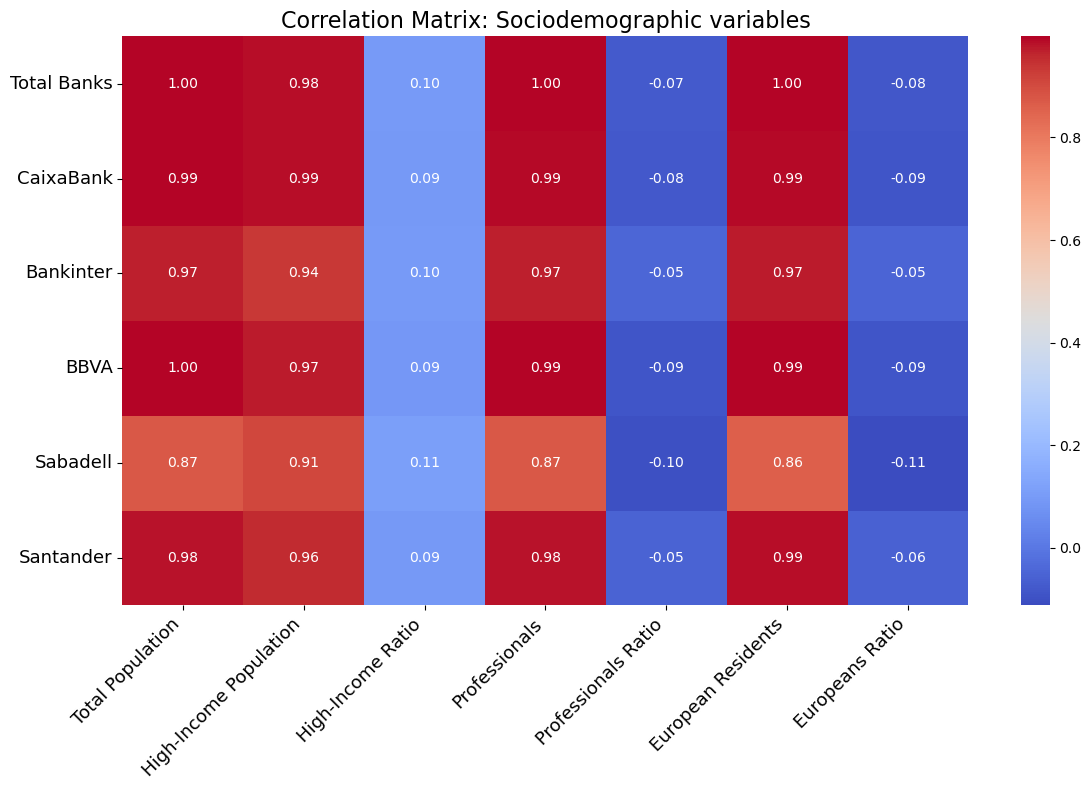

In [155]:
# Correlation table
correlation_matrix = df[bank_vars + socio_vars].corr()
correlation_table = correlation_matrix.loc[bank_vars, socio_vars]

# Rename rows and columns for the chart only
correlation_table.index = correlation_table.index.to_series().map(label_map)
correlation_table.columns = correlation_table.columns.to_series().map(label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Sociodemographic variables', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(rotation=0, fontsize=13)  
plt.tight_layout()
plt.show()

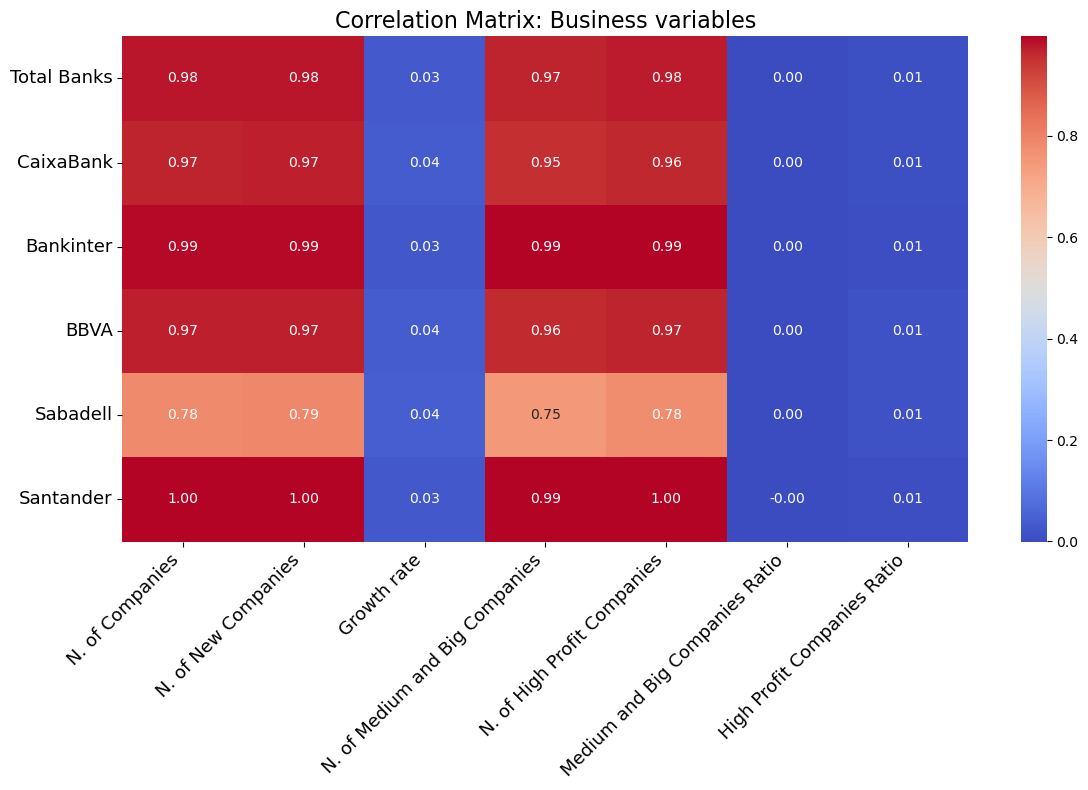

In [156]:
# Correlation table
correlation_matrix = df[bank_vars + business_vars].corr()
correlation_table = correlation_matrix.loc[bank_vars, business_vars]

# Rename rows and columns for the chart only
correlation_table.index = correlation_table.index.to_series().map(label_map)
correlation_table.columns = correlation_table.columns.to_series().map(label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Business variables', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(rotation=0, fontsize=13)  
plt.tight_layout()
plt.show()

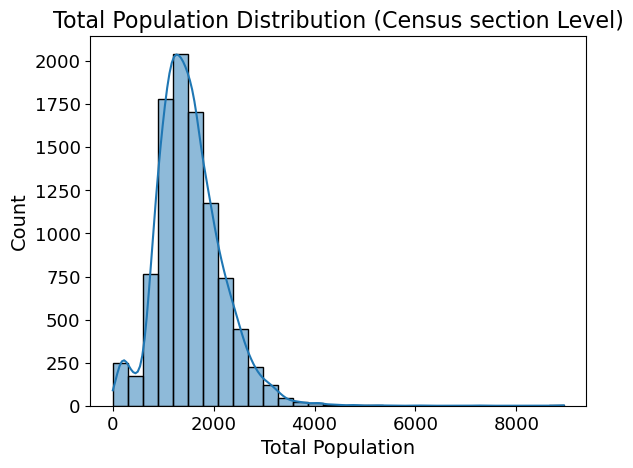

In [158]:
sns.histplot(sociodemo['tot_pob'], bins=30, kde=True)
plt.title('Total Population Distribution (Census section Level)', fontsize=16)
plt.xlabel('Total Population', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.show()

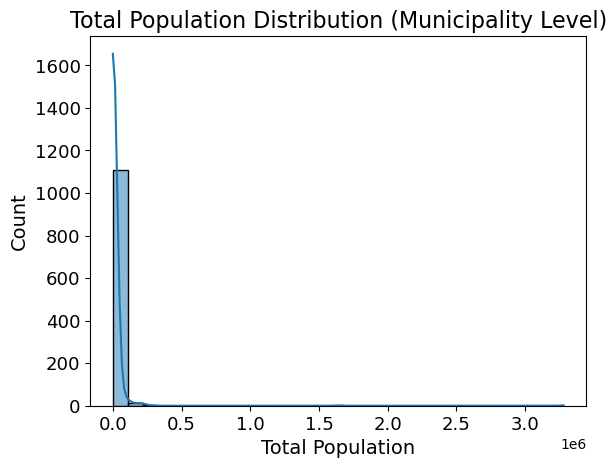

In [160]:
sns.histplot(df['tot_pob'], bins=30, kde=True)
plt.title('Total Population Distribution (Municipality Level)', fontsize=16)
plt.xlabel('Total Population', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.show()

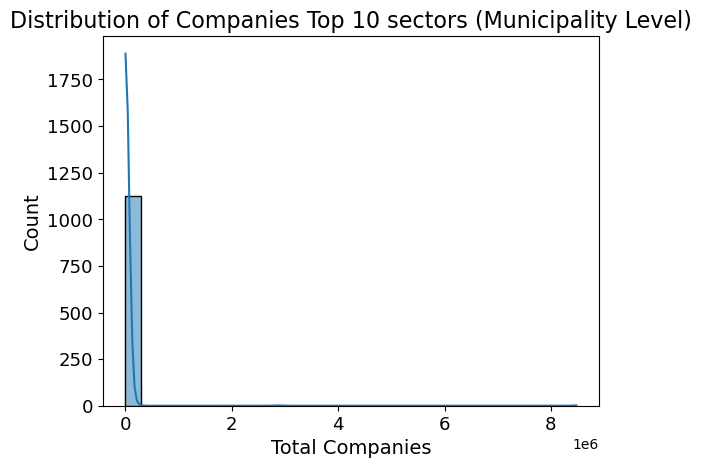

In [ ]:
# Histogram for total companies at Municipality level
sns.histplot(df['NumCompanies_10S'], bins=30, kde=True)
plt.title("Distribution of Companies Top 10 sectors (Municipality Level)", fontsize=16)
plt.xlabel("Total Companies", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.show()

#### **Step 7: Create model with HDBSCAN**
---

Clustering and score:
- Created a data frame for Madrid and Cataluña
- Scaled the features for Madrid and Cataluña
- Create composite scores (sociodemo_Score, Business_Score): These capture both absolute frequency (number of scores) and relative density (percentage). This is because the bank may be interested in both market volume and target concentration.
- Create Competitor_Score

In [163]:
# Create province column
df['municipality'] = df['municipality'].astype(str).str.zfill(5)
df['province'] = df['municipality'].apply(lambda x: 'Madrid' if x.startswith('28') else 'Cataluña')

# Create data frames for Madrid and Cataluña
df_cataluna = df[df['province'] == 'Cataluña'].copy()
df_madrid = df[df['province'] == 'Madrid'].copy()

7.1 MADRID

In [164]:
columns_to_score = [
    'high',
    'high_ratio',
    'professionals',
    'professionals_ratio',
    'europeans',
    'europeans_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_madrid[col].quantile(0.05)
    upper = df_madrid[col].quantile(0.95)
    
    # Normalization between percentil 5 and 95
    score = (df_madrid[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Assign the new column
    df_madrid[f'{col}_Score'] = score

In [165]:
df_madrid['Competitor_Score'] = 100 - df_madrid['banks_total_Score']

# Select columns that end with '_score'
score_columns = [col for col in df_madrid.columns if col.endswith('_Score')]
columns_needed = ['municipality', 'municipality_name'] + score_columns

# Create the subset
df_madrid_subset = df_madrid[columns_needed]
df_madrid_subset.to_csv("madrid.csv", index=False)

In [166]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_madrid['sociodemo_Score'] = 0.2*(
    df_madrid['high_Score'] +
    df_madrid['high_ratio_Score'] +
    df_madrid['professionals_Score'] +
    df_madrid['professionals_ratio_Score'] + 
    df_madrid['europeans_ratio_Score']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_madrid['Business_Score'] = (0.6*(df_madrid['NumCompanies_ML_10S_Score'] + df_madrid['companies_size_ratio_10S_Score']) + 
                        0.2*(df_madrid['NumCompanies_HP_10S_Score'] + df_madrid['companies_profit_ratio_10S_Score']) + 
                        0.2*(df_madrid['NumNewCompanies_10S_Score'] + df_madrid['growth_rate_10S_Score'])
                        )


In [167]:
# Features to use
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Standardize
scaler_madrid = MinMaxScaler()
df_scaled_madrid = pd.DataFrame(
    scaler_madrid.fit_transform(df_madrid[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_madrid.index
)

df_madrid = pd.concat([df_madrid, df_scaled_madrid], axis=1)

# Keep only observations with Competitor_score_norm different from 1 (without competitors)
df_madrid = df_madrid[df_madrid['Competitor_Score_norm'] != 1].copy()
df_scaled_madrid = df_scaled_madrid[df_scaled_madrid['Competitor_Score_norm'] != 1].copy()

# Clustering
clusterer_madrid = hdbscan.HDBSCAN(min_cluster_size=8, prediction_data=True)
df_madrid['hdbscan_cluster'] = clusterer_madrid.fit_predict(df_scaled_madrid)

print(df_madrid['hdbscan_cluster'].value_counts().sort_index())

df_madrid[df_madrid['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

hdbscan_cluster
-1    12
 0     9
 1    85
Name: count, dtype: int64


,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.579782,0.803183,0.272904
0,0.638465,0.720063,0.040286
1,0.284272,0.197197,0.868593


In [168]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_madrid['Zone_Score'] = (
    0.45 * df_madrid['sociodemo_Score_norm'] +
    0.45 * df_madrid['Business_Score_norm'] +
    0.1 * df_madrid['Competitor_Score_norm']
)

# Get top 10 zones per region
top10_madrid = df_madrid.nlargest(10, 'Zone_Score')[['municipality', 'Zone_Score', 'hdbscan_cluster', 'municipality_name']]
top10_madrid.reset_index(drop=True)

,municipality,Zone_Score,hdbscan_cluster,municipality_name
0,28903,0.881845,-1,Tres Cantos
1,28115,0.864960,-1,Pozuelo de Alarcón
2,28127,0.850769,-1,"Rozas de Madrid, Las"
3,28006,0.769493,0,Alcobendas
4,28022,0.714005,-1,Boadilla del Monte
5,28005,0.711826,-1,Alcalá de Henares
6,28079,0.674313,0,Madrid
7,28123,0.654363,0,Rivas-Vaciamadrid
8,28007,0.652666,0,Alcorcón
9,28074,0.639338,0,Leganés


7.2 CATALUÑA

In [169]:
columns_to_score = [
    'high',
    'high_ratio',
    'professionals',
    'professionals_ratio',
    'europeans',
    'europeans_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_cataluna[col].quantile(0.05)
    upper = df_cataluna[col].quantile(0.95)
    
    # Normalize between 5 and 95
    score = (df_cataluna[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Assing new column
    df_cataluna[f'{col}_Score'] = score

In [170]:
df_cataluna['Competitor_Score'] = 100 - df_cataluna['banks_total_Score']

# Select columns that end wih '_score'
score_columns = [col for col in df_cataluna.columns if col.endswith('_Score')]
columns_needed = ['municipality', 'municipality_name'] + score_columns

# Create the subset
df_cataluna_subset = df_cataluna[columns_needed]
df_cataluna_subset.to_csv("cataluna.csv", index=False)

In [171]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_cataluna['sociodemo_Score'] = 0.2*(
    df_cataluna['high_Score'] +
    df_cataluna['high_ratio_Score'] +
    df_cataluna['professionals_Score'] +
    df_cataluna['professionals_ratio_Score'] +
    df_cataluna['europeans_ratio_Score']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_cataluna['Business_Score'] = (0.6*(df_cataluna['NumCompanies_ML_10S_Score'] + df_cataluna['companies_size_ratio_10S_Score']) + 
                        0.2*(df_cataluna['NumCompanies_HP_10S_Score'] + df_cataluna['companies_profit_ratio_10S_Score']) + 
                        0.2*(df_cataluna['NumNewCompanies_10S_Score'] + df_cataluna['growth_rate_10S_Score'])
                        )


In [172]:
# Features to use
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Standardize
scaler_cataluna = MinMaxScaler()
df_scaled_cataluna = pd.DataFrame(
    scaler_cataluna.fit_transform(df_cataluna[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_cataluna.index
)

df_cataluna = pd.concat([df_cataluna, df_scaled_cataluna], axis=1)

# Keep only observations with Competitor_score_norm different from 1 (without competitors)
df_cataluna = df_cataluna[df_cataluna['Competitor_Score_norm'] != 1].copy()
df_scaled_cataluna = df_scaled_cataluna[df_scaled_cataluna['Competitor_Score_norm'] != 1].copy()

# Clustering
clusterer_cataluna = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
df_cataluna['hdbscan_cluster'] = clusterer_cataluna.fit_predict(df_scaled_cataluna)

print(df_cataluna['hdbscan_cluster'].value_counts().sort_index())

df_cataluna[df_cataluna['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

hdbscan_cluster
-1     67
 0     45
 1     19
 2    195
 3     35
 4     81
Name: count, dtype: int64


,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.549957,0.436914,0.286567
0,0.613656,0.752739,0.004444
1,0.400356,0.293652,0.189474
2,0.294609,0.162129,0.800000
3,0.296066,0.209316,0.400000
4,0.266778,0.203017,0.600000


In [173]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_cataluna['Zone_Score'] = (
    0.45 * df_cataluna['sociodemo_Score_norm'] +
    0.45 * df_cataluna['Business_Score_norm'] +
    0.1 * df_cataluna['Competitor_Score_norm']
)

# Get top 10 zones per region
top10_cataluna = df_cataluna.nlargest(10, 'Zone_Score')[['municipality', 'Zone_Score', 'hdbscan_cluster', 'municipality_name']]
top10_cataluna.reset_index(drop=True)

,municipality,Zone_Score,hdbscan_cluster,municipality_name
0,08238,0.814744,-1,Sant Quirze del Vallès
1,08221,0.778713,-1,Sant Just Desvern
2,08205,0.770833,-1,Sant Cugat del Vallès
3,08217,0.747208,0,Sant Joan Despí
4,08266,0.736583,0,Cerdanyola del Vallès
5,08260,0.725180,-1,Santa Perpètua de Mogoda
6,08123,0.704580,0,Molins de Rei
7,08169,0.694336,0,"Prat de Llobregat, El"
8,08077,0.685362,0,Esplugues de Llobregat
9,08086,0.679740,-1,"Franqueses del Vallès, Les"


#### **Step 8: Maps**
---

In [174]:
# Load the shapefile
shapefile_path = 'data/secciones_censales_sociodemo_2014.shp'
census = gpd.read_file(shapefile_path)

# Filter census df to include only Madrid and Cataluña using 'sscc' cusec column
census = census[census['sscc'].str.startswith(('08', '17', '25', '28', '43'))]

# Create 'municipality' column (sscc without the last 5 digits)
census['municipality'] = census['sscc'].str[:-5]

In [175]:
# Create sub census dataframes for Madrid and Cataluña
census_madrid = census[census['municipality'].str.startswith('28')].copy()
census_cataluna = census[census['municipality'].str.startswith(('08', '17', '25', '43'))].copy()

# Dissolve the census dataframes by municipality to create aggregated geometries
municipalities_madrid = census_madrid.dissolve(by='municipality')
municipalities_cataluna = census_cataluna.dissolve(by='municipality')

In [176]:
# Dissolve to get geometries by municipality
municipalities_madrid_2 = census_madrid.dissolve(by='municipality').reset_index()
municipalities_madrid_2 = municipalities_madrid_2[['municipality', 'geometry']]

municipalities_cataluna_2 = census_cataluna.dissolve(by='municipality').reset_index()
municipalities_cataluna_2 = municipalities_cataluna_2[['municipality', 'geometry']]

# Save as GeoJSON
municipalities_madrid_2.to_file('municipalities_madrid.geojson', driver='GeoJSON')
municipalities_cataluna_2.to_file('municipalities_cataluna.geojson', driver='GeoJSON')

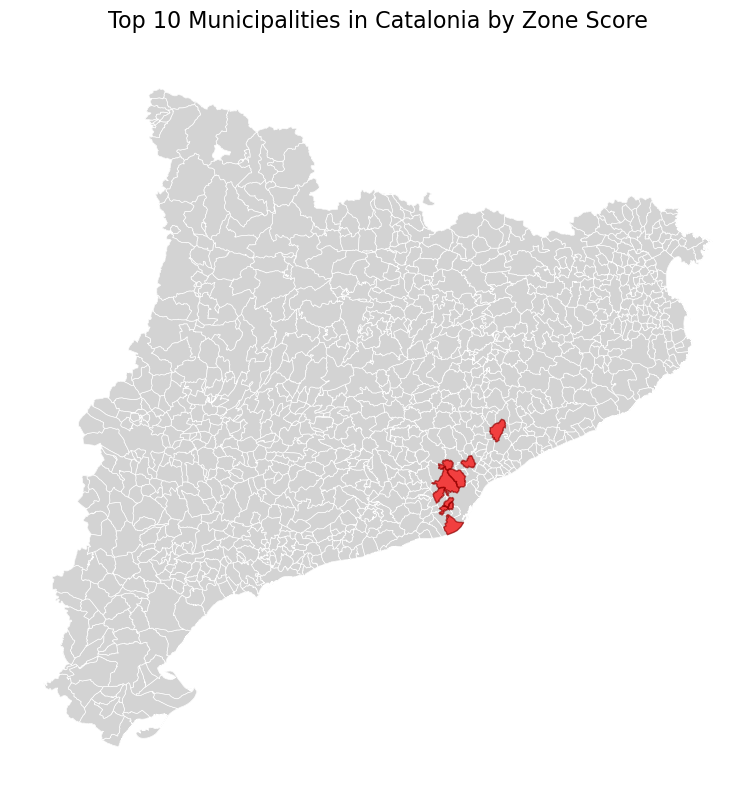

In [177]:
# Create the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all census areas in light gray
municipalities_cataluna.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.1)

# Get top 10 municipality codes
top10_codes = top10_cataluna['municipality'].tolist()

# Filter census data for top 10 municipalities and plot in red
municipalities_cataluna.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
top10_munis_cataluna = municipalities_cataluna.loc[municipalities_cataluna.index.isin(top10_codes)]
top10_munis_cataluna.plot(ax=ax, color='red', alpha=0.7, edgecolor='darkred', linewidth=1)

# Clean up the map
ax.set_title('Top 10 Municipalities in Catalonia by Zone Score', fontsize=16, pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

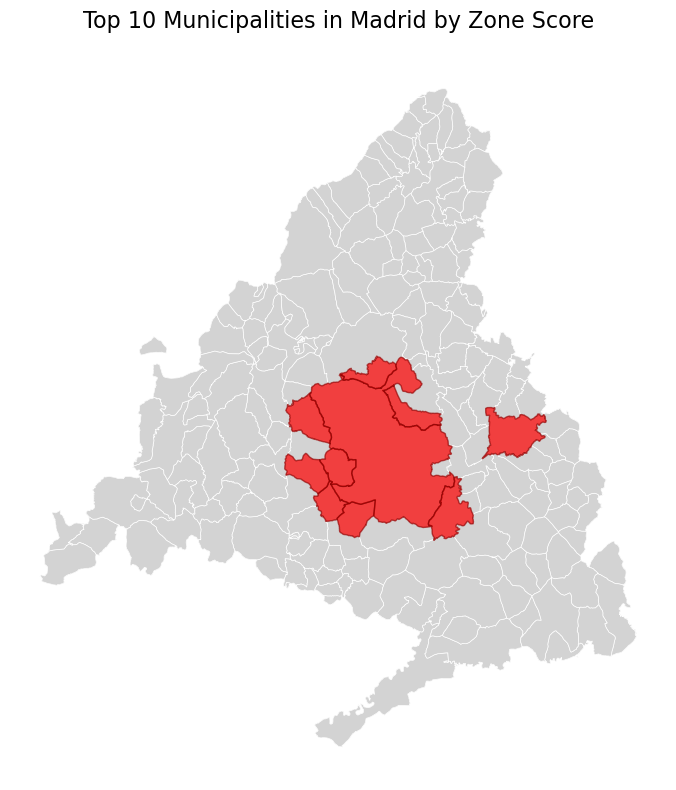

In [178]:
# Create the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all census areas in light gray
municipalities_madrid.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.1)

# Get top 10 municipality codes
top10_codes = top10_madrid['municipality'].tolist()

# Filter census data for top 10 municipalities and plot in red
municipalities_madrid.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
top10_munis_madrid = municipalities_madrid.loc[municipalities_madrid.index.isin(top10_codes)]
top10_munis_madrid.plot(ax=ax, color='red', alpha=0.7, edgecolor='darkred', linewidth=1)

# Clean up the map
ax.set_title('Top 10 Municipalities in Madrid by Zone Score', fontsize=16, pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

In [339]:
# calculate branch density by 1000
df['branch_density_per_1000'] = (df['banks_total'] / df['tot_pob']) * 1000

In [352]:
# Create new df of top 5 municipalities by branch density and bottom 5
top5_branch_density = df.nlargest(5, 'branch_density_per_1000')[['municipality', 'municipality_name', 'branch_density_per_1000']]
bottom5_branch_density = df.nsmallest(5, 'branch_density_per_1000')[['municipality', 'municipality_name', 'branch_density_per_1000']]

In [353]:
top5_branch_density

,municipality,municipality_name,branch_density_per_1000
415,25226,Torrebesses,3.333333
239,25020,Almatret,3.311258
294,25081,"Espluga Calba, L'",3.021148
329,25126,Llavorsí,2.915452
256,25039,Baix Pallars,2.898551


In [354]:
bottom5_branch_density

,municipality,municipality_name,branch_density_per_1000
1,17002,Aiguaviva,0.0
2,17003,Albanyà,0.0
3,17004,Albons,0.0
4,17005,"Far d'Empordà, El",0.0
9,17010,Argelaguer,0.0


In [356]:
df_madrid = df_madrid.set_index('municipality')
df_madrid['branch_density_per_1000'] = df_madrid['branch_density_per_1000'].astype(float)
densities_munis_madrid = municipalities_madrid.join(df_madrid['branch_density_per_1000'], on='municipality')

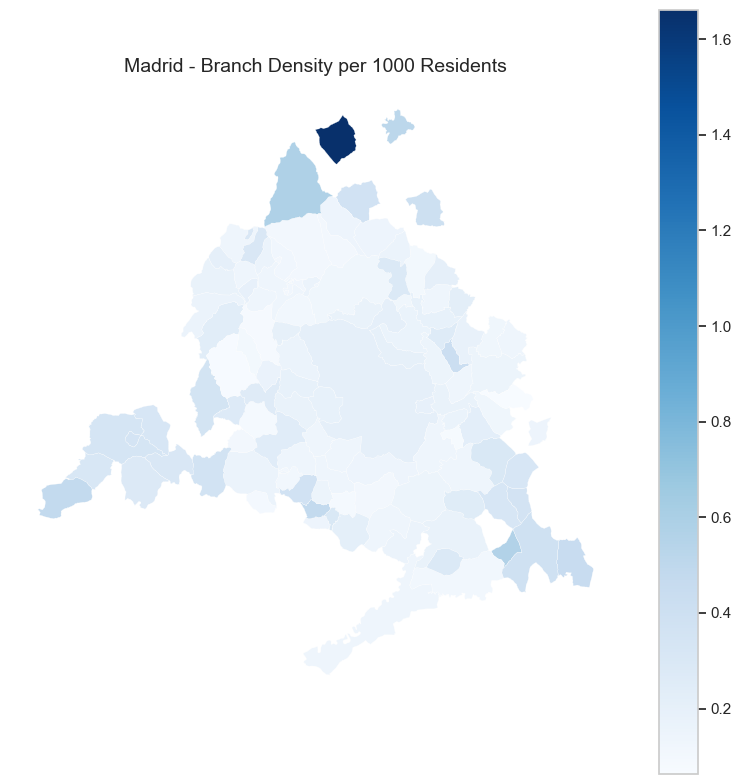

In [361]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot with color scale
densities_munis_madrid.plot(
    column='branch_density_per_1000',
    cmap='Blues',            # You can use 'viridis', 'YlOrRd', etc.
    linewidth=0.2,
    edgecolor='white',
    legend=True,
    ax=ax
)

# Clean up the plot
ax.set_title('Madrid - Branch Density per 1000 Residents', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

In [358]:
df_cataluna = df_cataluna.set_index('municipality')
df_cataluna['branch_density_per_1000'] = df_cataluna['branch_density_per_1000'].astype(float)
densities_munis_cataluna = municipalities_cataluna.join(df_cataluna['branch_density_per_1000'], on='municipality')

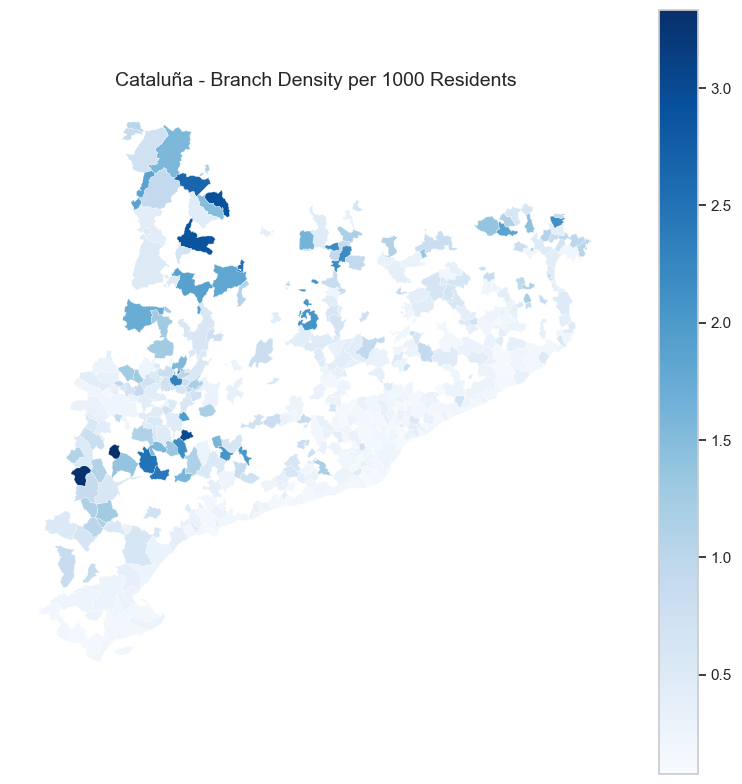

In [360]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot with color scale
densities_munis_cataluna.plot(
    column='branch_density_per_1000',
    cmap='Blues',            # You can use 'viridis', 'YlOrRd', etc.
    linewidth=0.2,
    edgecolor='white',
    legend=True,
    ax=ax
)

# Clean up the plot
ax.set_title('Cataluña - Branch Density per 1000 Residents', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Convert all df to csv files 
df.to_csv('df_final.csv', index=False)
df_cataluna.to_csv('df_cataluna.csv', index=False)
df_madrid.to_csv('df_madrid.csv', index=False)

#### **Step 9: Insights from competitor analysis**
---

In [ ]:
bank_columns = [col for col in df_madrid.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]
competitor_totals_madrid = df_madrid[bank_columns].sum().sort_values(ascending=False)

In [ ]:
bank_columns = [col for col in df_cataluna.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]
competitor_totals_cataluna = df_cataluna[bank_columns].sum().sort_values(ascending=False)

In [ ]:
[col for col in df_madrid.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]

['banks_Bankinter', 'banks_CaixaBank', 'banks_Sabadell', 'banks_Santander']

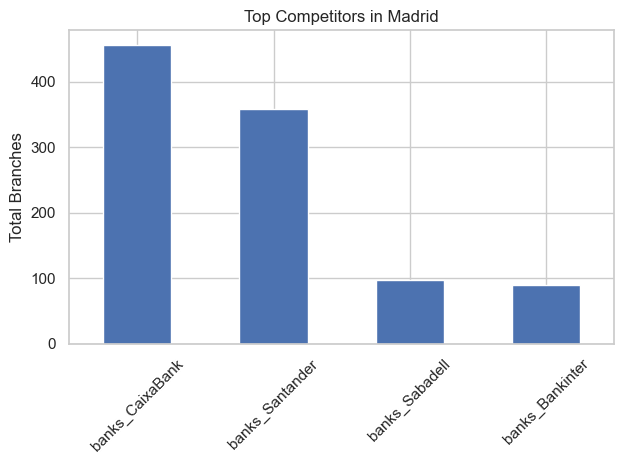

In [ ]:
competitor_totals_madrid.plot(kind='bar', title='Top Competitors in Madrid')
plt.ylabel("Total Branches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

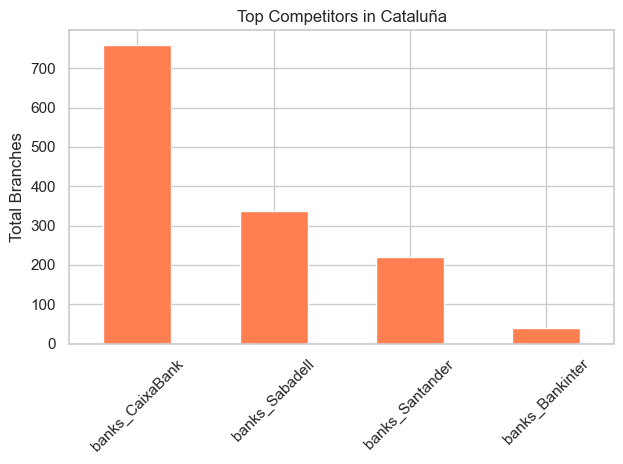

In [ ]:
# Bar plot for Cataluña
competitor_totals_cataluna.plot(kind='bar', title='Top Competitors in Cataluña', color='coral')
plt.ylabel("Total Branches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

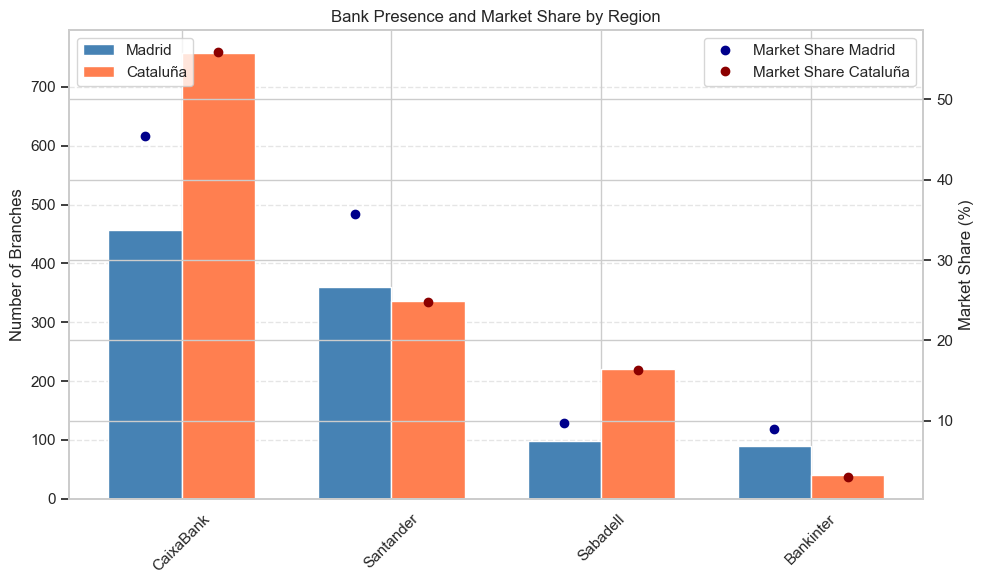

In [ ]:
# Clean names and drop total rows
def clean_labels(series):
    return series.rename(lambda x: x.replace('banks_', ''))

exclude = ['banks_total', 'banks_total_score']
madrid = competitor_totals_madrid.drop([col for col in exclude if col in competitor_totals_madrid])
cataluna = competitor_totals_cataluna.drop([col for col in exclude if col in competitor_totals_cataluna])

madrid = clean_labels(madrid)
cataluna = clean_labels(cataluna)

# Market shares
madrid_pct = (madrid / madrid.sum()) * 100
cataluna_pct = (cataluna / cataluna.sum()) * 100

# Setup
labels = madrid.index
x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: number of branches
bars1 = ax1.bar(x - width/2, madrid.values, width, label='Madrid', color='steelblue')
bars2 = ax1.bar(x + width/2, cataluna.values, width, label='Cataluña', color='coral')
ax1.set_ylabel('Number of Branches')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line chart: market share
ax2 = ax1.twinx()
ax2.plot(x - width/2, madrid_pct.values, 'o', color='darkblue', label='Market Share Madrid')
ax2.plot(x + width/2, cataluna_pct.values, 'o', color='darkred', label='Market Share Cataluña')
ax2.set_ylabel('Market Share (%)')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Bank Presence and Market Share by Region')
plt.tight_layout()
plt.show()

I will combine Madrid and Cataluna regions for training the models. I will add a label for province to flag Madrid vs Cataluna.

In [ ]:
# First, ensure that both dataframes have the same structure
# You can inspect this:
print(df_madrid.columns.symmetric_difference(df_cataluna.columns))

Index([], dtype='object')


In [ ]:
# Add the 'province' column to both
df_madrid['province'] = 'Madrid'
df_cataluna['province'] = 'Cataluña'

# Combine the dataframes
df_combined = pd.concat([df_madrid, df_cataluna], ignore_index=True)

# Optional sanity check
print(df_combined['province'].value_counts())
print(df_combined.shape)
df_combined.head()

province
Cataluña    442
Madrid      106
Name: count, dtype: int64
(548, 46)


,municipality,tot_pob,high,professionals,europeans,nse_municip,NumCompanies_10S,NumNewCompanies_10S,NumCompanies_ML_10S,NumCompanies_HP_10S,...,companies_profit_ratio_10S_score,banks_total_score,sociodemo_Score,Business_Score,Competitor_Score,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm,hdbscan_cluster,Zone_Score
0,28002,4751,149.543524,1741.617279,4128,4.174049,954.0,34.0,40.0,82.0,...,100.000000,11.695906,18.579325,86.429931,88.304094,0.229819,0.468416,0.883041,1,0.402510
1,28004,10123,38.293007,3583.988163,8649,3.412468,1100.0,128.0,8.0,4.0,...,5.272727,5.847953,13.576152,29.822525,94.152047,0.167269,0.161626,0.941520,1,0.242155
2,28005,196888,6419.666709,57812.172692,167203,3.936076,104746.0,6564.0,3712.0,5897.0,...,81.632234,100.000000,50.710843,184.515177,0.000000,0.631528,1.000000,0.000000,0,0.734187
3,28006,117041,14561.594265,43447.451233,101142,5.035895,132126.0,9603.0,3015.0,5055.0,...,55.475455,100.000000,73.293354,159.396341,0.000000,0.913855,0.863866,0.000000,0,0.799974
4,28007,170296,3758.188589,51881.399910,155156,3.771680,112852.0,7579.0,2603.0,5313.0,...,68.265073,100.000000,41.697761,161.618883,0.000000,0.518846,0.875911,0.000000,0,0.627641


In [ ]:
# defining features and subfeatures later to be used in the models
features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']
feature_2 = [
    'high_score',
    'high_ratio_score',
    'professionals_score',
    'professionals_ratio_score',
    'europeans_ratio',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

## 9.1. Competitor Analysis - CaixaBank

In [ ]:
# understanding our target
print(df_combined['banks_CaixaBank'].describe())
print(df_combined['banks_CaixaBank'].value_counts())

count    548.000000
mean       2.215328
std       11.693261
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      233.000000
Name: banks_CaixaBank, dtype: float64
banks_CaixaBank
1.0      449
2.0       35
3.0       14
4.0       13
0.0        8
6.0        5
5.0        5
12.0       4
8.0        4
9.0        3
10.0       3
233.0      1
11.0       1
142.0      1
7.0        1
16.0       1
Name: count, dtype: int64


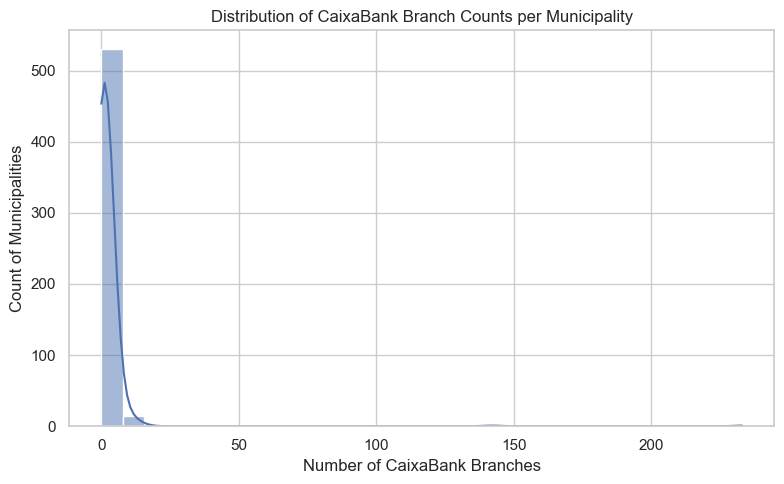

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_combined['banks_CaixaBank'], bins=30, kde=True)
plt.title("Distribution of CaixaBank Branch Counts per Municipality")
plt.xlabel("Number of CaixaBank Branches")
plt.ylabel("Count of Municipalities")
plt.tight_layout()
plt.show()

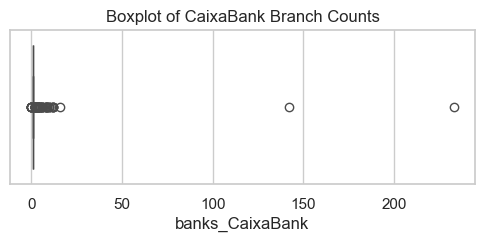

In [ ]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_combined['banks_CaixaBank'])
plt.title("Boxplot of CaixaBank Branch Counts")
plt.show()

The target (banks_CaixaBank) is clearly right-skewed count data:

- The median is 1.

- Most values are 1 or 0 (very sparse).

- A few outliers go above 200.

We have to take this into consideration when modeling.

We will train a **Gradient Boosting Classifier** to predict the level of CaixaBank presence in municipalities, categorized into four classes:

- `none`: 0 branches  
- `low`: 1–2 branches  
- `medium`: 3–9 branches  
- `high`: ≥10 branches

In [ ]:
# create new target - we make it a multiclass classification problem instead
def classify_branch_level(x):
    if x == 0:
        return 'none'
    elif x <= 2:
        return 'low'
    elif x <= 9:
        return 'medium'
    else:
        return 'high'

df_combined['caixabank_level'] = df_combined['banks_CaixaBank'].apply(classify_branch_level)

# Check distribution
print(df_combined['caixabank_level'].value_counts())

caixabank_level
low       484
medium     45
high       11
none        8
Name: count, dtype: int64


In [ ]:
# Prepare features and target
X = df_combined[features]
y_raw = df_combined['caixabank_level']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Train model
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.91      0.93      0.92        97
         low       0.97      0.88      0.92        97
      medium       0.89      0.90      0.89        97
        none       0.93      0.99      0.96        97

    accuracy                           0.92       388
   macro avg       0.92      0.92      0.92       388
weighted avg       0.92      0.92      0.92       388



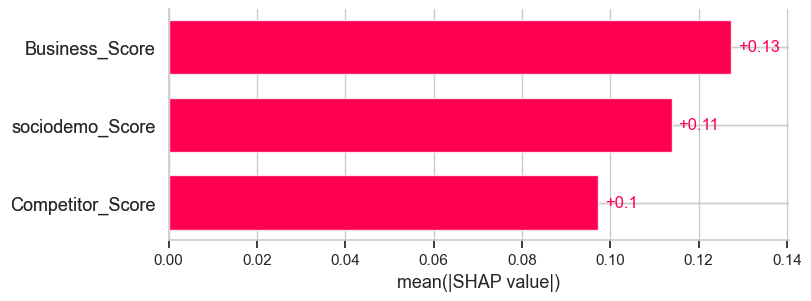

In [ ]:
# Create SHAP explainer using predict_proba
explainer = shap.Explainer(clf.predict_proba, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 0], max_display=10)

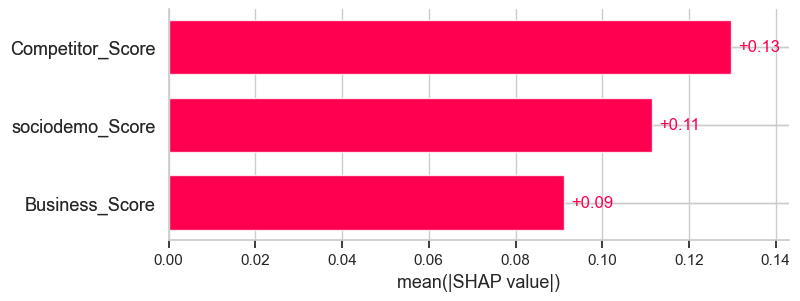

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 1], max_display=10)

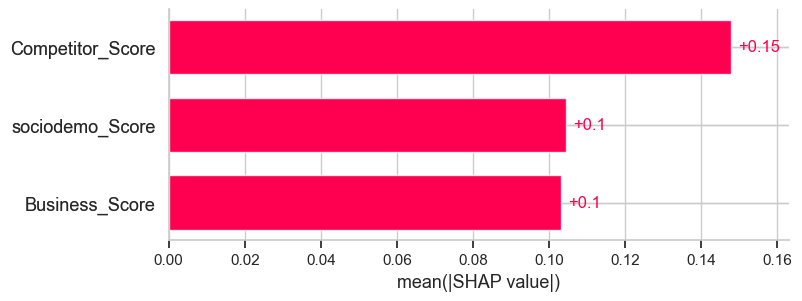

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 2], max_display=10)

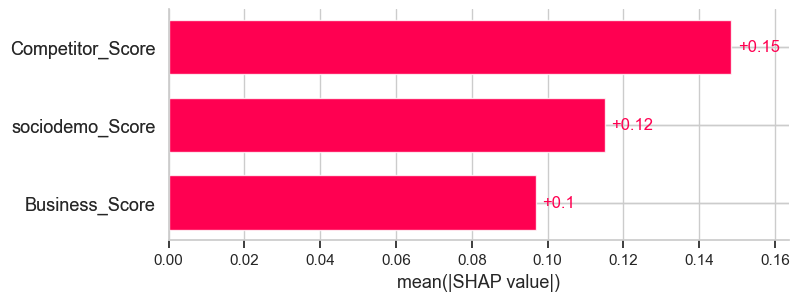

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 3], max_display=10)

**SHAP Bar Plot Interpretation per Class for CaixaBank**

**Class 0 – `none` (No Branches)**

- **Top Feature:** `Business_Score`
- `sociodemo_Score` also contributes notably, while `Competitor_Score` plays a lesser role.
- **Insight:** Branch absence is mainly driven by low business and sociodemographic potential — not competition. CaixaBank avoids areas with weak market fundamentals, regardless of competition levels.

---

**Class 1 – `low` (1–2 Branches)**
- **Top Feature:** `Competitor_Score`
- Suggests CaixaBank tolerates competition in smaller markets but limits its investment.
- **Insight:** Presence exists even in competitive environments, likely due to necessity rather than opportunity.

---

**Class 2 – `medium` (3–9 Branches)**
- `Competitor_Score` dominates, followed by moderate influence from `sociodemo_Score` and `Business_Score`.
- **Insight:** The decision to maintain a mid-sized presence is still influenced primarily by competitive gaps.

---

**Class 3 – `high` (10+ Branches)**
- **Top Feature:** `Competitor_Score` again leads.
- `sociodemo_Score` and `Business_Score` both contribute more evenly than in other classes.
- **Insight:** CaixaBank maximizes presence where competition is weak and the business + sociodemographic potential is strong.


In [ ]:
# Features and target
# Correctly select those columns
X = df_combined[feature_2]  # Use double brackets to keep it as DataFrame
y_raw = df_combined['caixabank_level']

# Encode target
le = LabelEncoder()
y = le.fit_transform(y_raw)

# ✅ Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Then SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.67      1.00      0.80         2
         low       0.98      0.91      0.94        97
      medium       0.64      0.78      0.70         9
        none       0.17      0.50      0.25         2

    accuracy                           0.89       110
   macro avg       0.61      0.80      0.67       110
weighted avg       0.93      0.89      0.91       110



PermutationExplainer explainer: 111it [00:12,  1.87it/s]                         


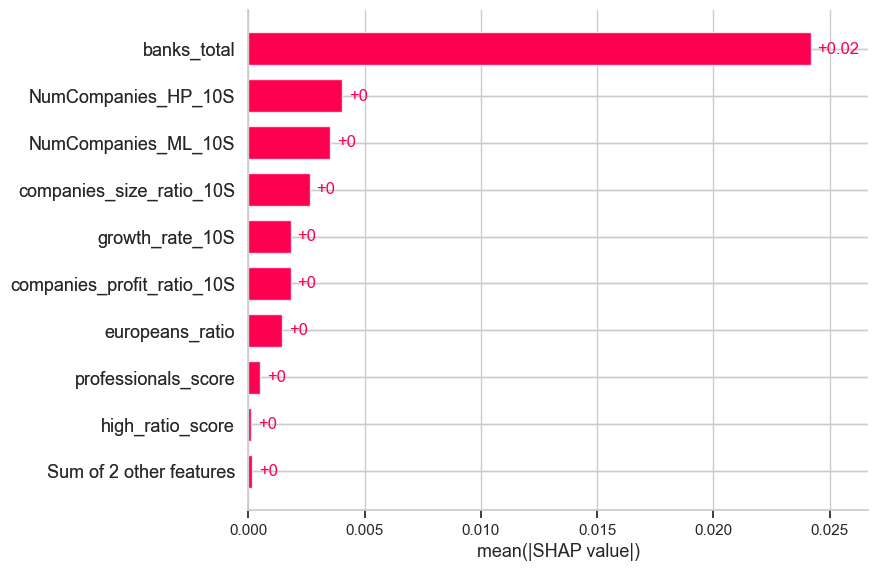

In [ ]:
# Create SHAP explainer using predict_proba
explainer = shap.Explainer(clf.predict_proba, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 0], max_display=10)

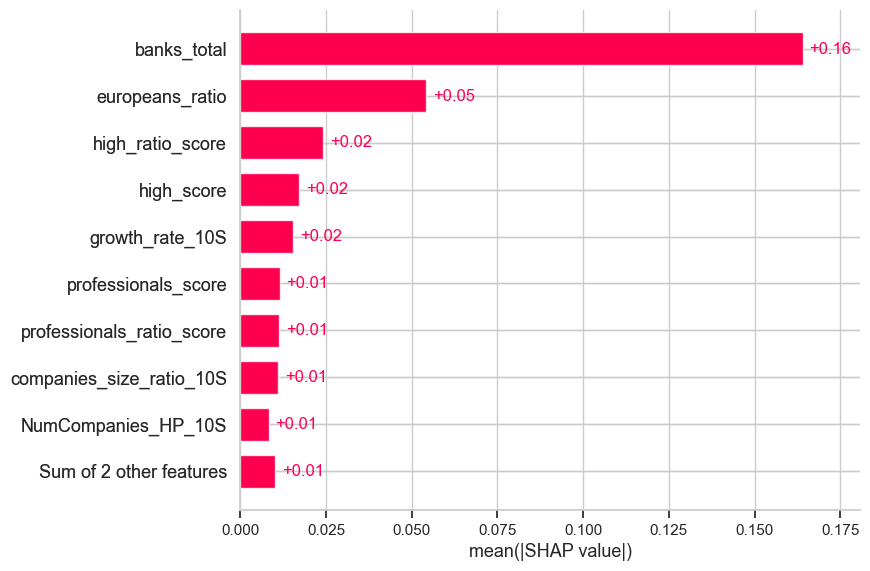

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 1], max_display=10)

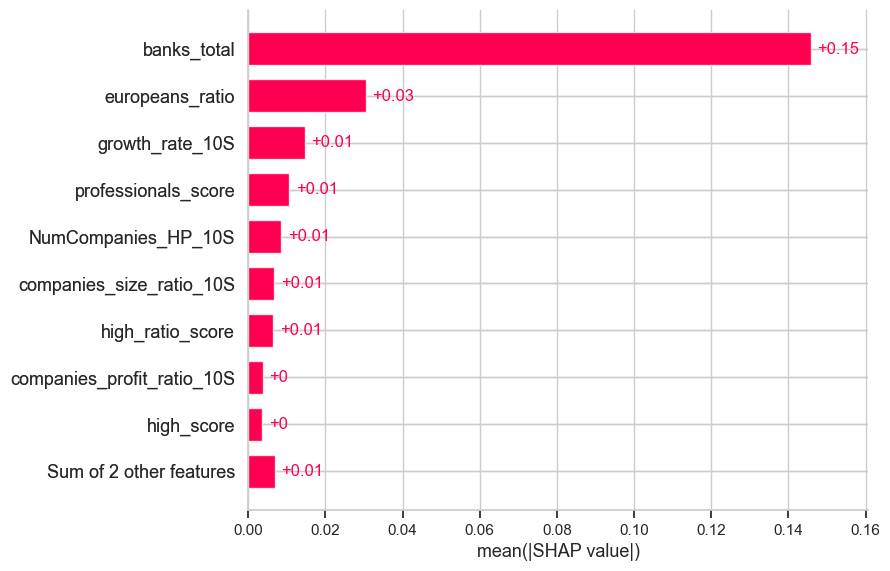

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 2], max_display=10)

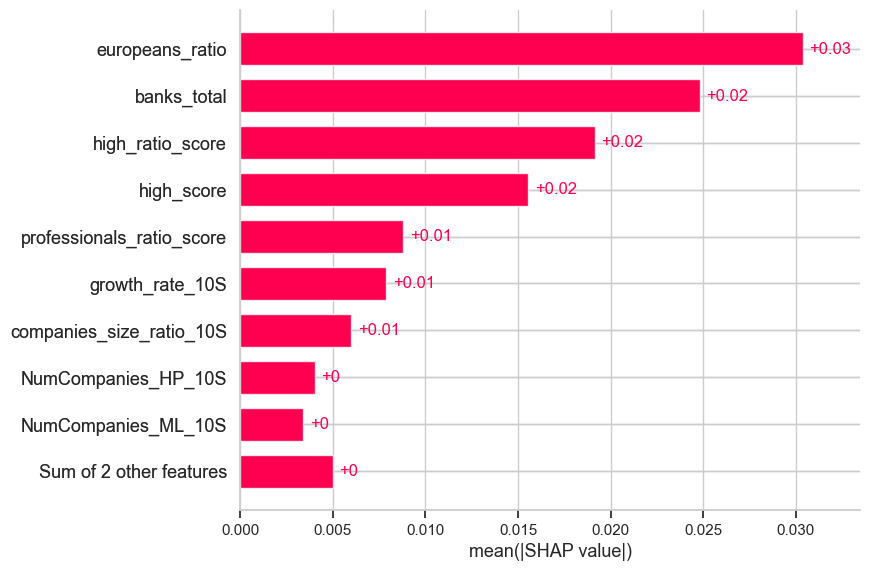

In [ ]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 3], max_display=10)

## I have to repeat this approach for the other banks, and also split Madrid from Catuba

In [ ]:
# -------------------------
# SHAP Explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# -------------------------
# SHAP Bar Plot
shap.plots.bar(shap_values, max_display=12)
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [ ]:
shap_compare.plot(kind='barh', figsize=(10, 6))
plt.title("Mean |SHAP| Values by Province (Madrid vs Cataluña)")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Use only the composite features
features_only = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Step 2: Prepare data
X = df_combined[features_only]
y = np.log1p(df_combined['banks_CaixaBank'])

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Step 4: Train the model (Random Forest as before)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Step 6: Attach province for comparison
X_test_with_province = X_test.copy()
X_test_with_province['province'] = df_combined.loc[X_test.index, 'province']

# Step 7: Separate by region
madrid_idx = X_test_with_province[X_test_with_province['province'] == 'Madrid'].index
cataluna_idx = X_test_with_province[X_test_with_province['province'] == 'Cataluña'].index

# Step 8: Get SHAP values per region
shap_values_df = pd.DataFrame(shap_values.values, columns=features_only, index=X_test.index)
shap_values_madrid = shap_values_df.loc[madrid_idx]
shap_values_cataluna = shap_values_df.loc[cataluna_idx]

# Step 9: Compute mean |SHAP| per feature
mean_shap_madrid = shap_values_madrid.abs().mean().rename("Madrid")
mean_shap_cataluna = shap_values_cataluna.abs().mean().rename("Cataluña")

# Step 10: Plot
shap_compare = pd.concat([mean_shap_madrid, mean_shap_cataluna], axis=1)
shap_compare.plot(kind='barh', figsize=(8, 5))
plt.title("Mean |SHAP| Values by Province – Composite Features")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

### 9.2. Santander

In [ ]:
# ----------------------------
#  Prepare target and features
# ----------------------------
df_combined['log_target'] = np.log1p(df_combined['banks_Santander'])

X = df_combined[features]
y = df_combined['log_target']

# ----------------------------
# 3. Train-test split and model
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# -----------------------------------
# 4. Evaluate model performance
# -----------------------------------
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Santander Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Santander)")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# 4. Compute SHAP values
# ----------------------------
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# ----------------------------
# 5. Separate by province
# ----------------------------
X_test_with_province = X_test.copy()
X_test_with_province['province'] = df_combined.loc[X_test.index, 'province']

madrid_idx = X_test_with_province[X_test_with_province['province'] == 'Madrid'].index
cataluna_idx = X_test_with_province[X_test_with_province['province'] == 'Cataluña'].index

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns, index=X_test.index)
shap_values_madrid = shap_values_df.loc[madrid_idx]
shap_values_cataluna = shap_values_df.loc[cataluna_idx]

# ----------------------------
# 6. Compute mean |SHAP| per feature
# ----------------------------
mean_shap_madrid = shap_values_madrid.abs().mean().rename("Madrid")
mean_shap_cataluna = shap_values_cataluna.abs().mean().rename("Cataluña")

shap_compare = pd.concat([mean_shap_madrid, mean_shap_cataluna], axis=1)

# ----------------------------
# 7. Plot with + values
# ----------------------------
def plot_shap_with_labels(shap_df, title="Mean |SHAP| Values by Province", xlabel="Mean Absolute SHAP Value"):
    shap_df_sorted = shap_df.sort_values(by='Madrid', ascending=False)
    features = shap_df_sorted.index
    values_madrid = shap_df_sorted['Madrid'].values
    values_cataluna = shap_df_sorted['Cataluña'].values

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.barh(x - width/2, values_madrid, width, label='Madrid', color='steelblue')
    bars2 = ax.barh(x + width/2, values_cataluna, width, label='Cataluña', color='coral')

    for i, (v1, v2) in enumerate(zip(values_madrid, values_cataluna)):
        ax.text(v1 + 0.001, i - width/2, f'+{v1:.2f}', va='center', fontsize=9)
        ax.text(v2 + 0.001, i + width/2, f'+{v2:.2f}', va='center', fontsize=9)

    ax.set_yticks(x)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Show it
plot_shap_with_labels(
    shap_compare,
    title="Mean |SHAP| Values by Province – Santander (Composite Features)"
)

In [ ]:
# ---------------------------
# 2. Prepare target and features
# ----------------------------
df_combined['log_target'] = np.log1p(df_combined['banks_Santander'])

X = df_combined[feature_2]
y = df_combined['log_target']

# ----------------------------
# 3. Train-test split and model
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ----------------------------
# 4. Predictions and evaluation
# ----------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Santander Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Santander - Subfeatures)")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. SHAP values
# ----------------------------
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP bar plot
shap.plots.bar(shap_values, max_display=12)

### 9.3. Sabadell

In [ ]:
# Log-transform the target
df_combined['log_target'] = np.log1p(df_combined['banks_Sabadell'])

# Prepare input and output
X = df_combined[features]
y = df_combined['log_target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Sabadell Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Sabadell - Composite Features)")
plt.tight_layout()
plt.show()

In [ ]:
# Prepare input/output with sub-features
X = df_combined[feature_2]
y = np.log1p(df_combined['banks_Sabadell'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Sabadell Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Sabadell - Subfeatures)")
plt.tight_layout()
plt.show()

#### **Step 10: Final conclusions**
---